# Features Extraction
In this notebook, I will demonstrate how to extract feature(car's features) from an image. I use conventional method to do extraction so-called [`Histogram Oriented Gradient`](https://www.learnopencv.com/histogram-of-oriented-gradients/)

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import random
from skimage.feature import hog

Load sample images

In [2]:
sample_images_dir = 'test_images'
sample_images = [mpimg.imread(p) for p in glob.glob(os.path.join(sample_images_dir, '*.jpg'))]
sample_images_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in sample_images]

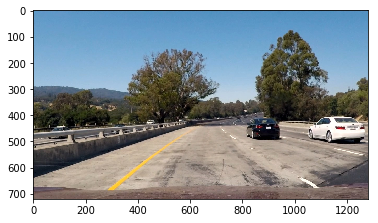

In [3]:
plt.imshow(sample_images[random.randint(0, len(sample_images)-1)])

In [4]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
feature_extraction_params = {
    'resize_h': 64,
    'resize_w': 64,
    'color_space': 'YCrCb',
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL',
    'spatial_size': (32, 32), # spatial binning dimensions
    'hist_bins': 16,
    'spatial_feature': True,
    'hist_feature': True,
    'hog_feature': True,
}

In [5]:
if not os.path.exists('output_image'):
    os.makedirs('output_image')

/home/jameschien/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


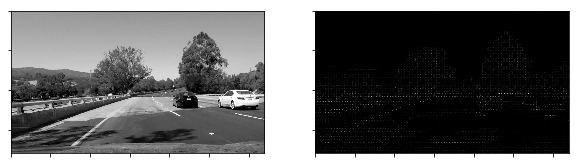

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, verbose=False, feature_vec=True):
    if verbose:
        features, hog_image = hog(img, orientations=orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 transform_sqrt=True,
                                 visualise=verbose, feature_vector=feature_vec)
        f, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(img, cmap='gray')
        ax[1].imshow(hog_image, cmap='gray')
        plt.setp([_ax.get_xticklabels() for _ax in ax.ravel()], visible=False)
        plt.setp([_ax.get_yticklabels() for _ax in ax.ravel()], visible=False)
        plt.savefig(os.path.join('output_image', 'hog_features.jpg'))
        plt.show()
        
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                     pixels_per_cell=(pix_per_cell, pix_per_cell),
                     cells_per_block=(cell_per_block, cell_per_block),
                     transform_sqrt=True,
                     visualise=verbose, feature_vector=feature_vec)
        return features

_, _ = get_hog_features(sample_images_gray[0], 
                                       orient=feature_extraction_params['orient'], 
                                       pix_per_cell=feature_extraction_params['pix_per_cell'], 
                                       cell_per_block=feature_extraction_params['cell_per_block'], 
                                       verbose=True)

In [7]:
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel()

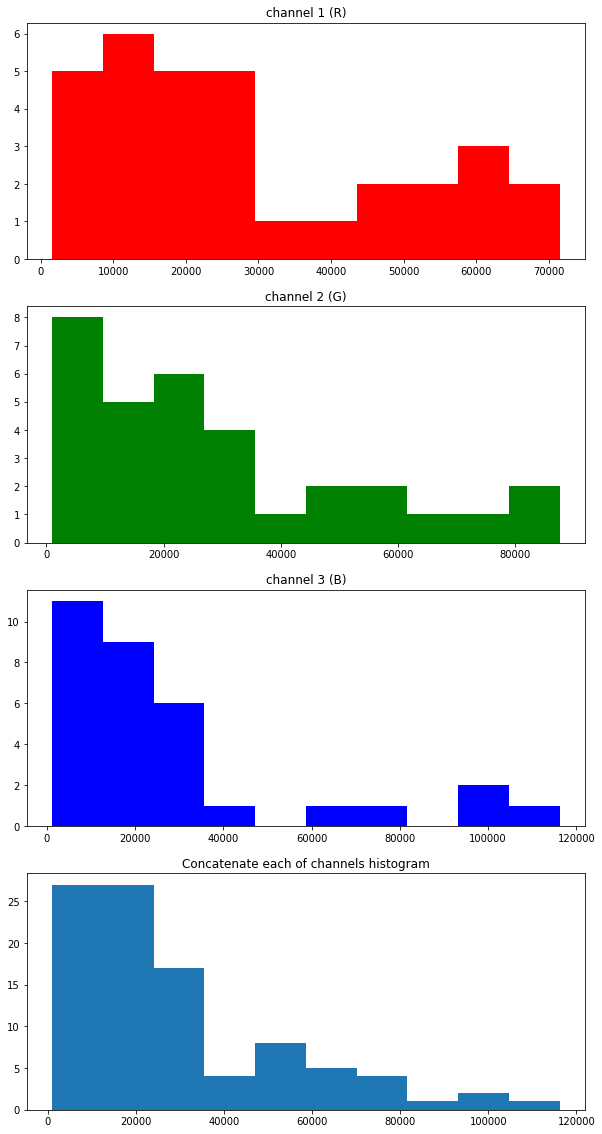

In [8]:
def color_hist(img, nbins=32, bins_range=(0, 256), verbose=False):
    ch1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    ch2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    ch3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    if verbose:
        f, ax = plt.subplots(4, 1, figsize=(10, 20))
        ax[0].set_title('channel 1 (R)')
        ax[0].hist(ch1_hist[0], color='r', histtype='barstacked')
        ax[1].set_title('channel 2 (G)')
        ax[1].hist(ch2_hist[0], color='g', histtype='barstacked')
        ax[2].set_title('channel 3 (B)')
        ax[2].hist(ch3_hist[0], color='b', histtype='barstacked')
        ax[3].set_title('Concatenate each of channels histogram')
        ax[3].hist(hist_features)
        plt.savefig(os.path.join('output_image', 'color_hist.jpg'))
        plt.show()
    return hist_features

_ = color_hist(sample_images[0], verbose=True)

In [9]:
def image_to_features(img, params):
    color_space = params['color_space']
    spatial_size = params['spatial_size']
    hist_bins = params['hist_bins']
    orient = params['orient']
    pix_per_cell = params['pix_per_cell']
    cell_per_block = params['cell_per_block']
    hog_channel = params['hog_channel']
    spatial_feature = params['spatial_feature']
    hist_feature = params['hist_feature']
    hog_feature = params['hog_feature']
    
    image_features = []
    
    if color_space != 'RGB':
        range_of_color_space = [('HSV', cv2.COLOR_RGB2HSV), 
                                ('LUV', cv2.COLOR_RGB2LUV),
                                ('HLS', cv2.COLOR_RGB2HLS),
                                ('YUV', cv2.COLOR_RGB2YUV),
                                ('YCrCb', cv2.COLOR_RGB2YCrCb)]
        
        for color_type, cv2_type in range_of_color_space:
            if color_space == color_type:
                feature_image = cv2.cvtColor(img, cv2_type)
                break
    else:
        feature_image = np.copy(img)
    
    if spatial_feature:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        image_features.append(spatial_features)
    
    if hist_feature:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        image_features.append(hist_features)
    
    if hog_feature:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block, 
                                                     verbose=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, 
                                            verbose=False, feature_vec=True)
        image_features.append(hog_features)

    return np.concatenate(image_features)

In [10]:
def extract_features_from_file_list(file_list, params):    
    h, w = params['resize_h'], params['resize_w']
    features = []
    for file in file_list:
        feature = image_to_features(cv2.resize(file, (h, w)), params)
        features.append(feature)
    return features

In [11]:
def cvt_color(img, dest='YCrCb'):
    range_of_color_space = {
        'GRAY': cv2.COLOR_RGB2GRAY, 
        'LUV': cv2.COLOR_RGB2LUV,
        'YUV': cv2.COLOR_RGB2YUV,
        'YCrCb': cv2.COLOR_RGB2YCrCb,
    }
    return cv2.cvtColor(img, range_of_color_space[dest])